### Deep Learning Miniproject - Audio

AVS 8th Semester - Group 841

In [1]:
import pandas as pd

#from IPython.display import Audio
import IPython.display as ipd

import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
from torch import nn
#from transformers import ASTFeatureExtractor
from torch.utils.data import random_split, DataLoader, Dataset
import pytorch_lightning as pl
import torchaudio as ta

c:\Users\jespe\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


#### 1. Explore the dataset through code

a. How many samples does the dataset contain?

In [17]:
#Load the data!
#PATH = "./data/metadata_compiled.csv"
PATH = "./metadata_compiled.csv"
df = pd.read_csv(PATH)

#Check no. samples
print(f'Number of samples : {df.shape[0]}')

Number of samples : 27550


b. How many classes? How many samples per class? Show a histogram of the number of intances per class

In [18]:
print(f'Number of classes: {len(df["status"].unique())}.\n\
    Classes: {df["status"].unique()}\n\
    {pd.value_counts(df["status"], dropna=False)}')

Number of classes: 4.
    Classes: [nan 'healthy' 'COVID-19' 'symptomatic']
    healthy        12479
NaN            11326
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64


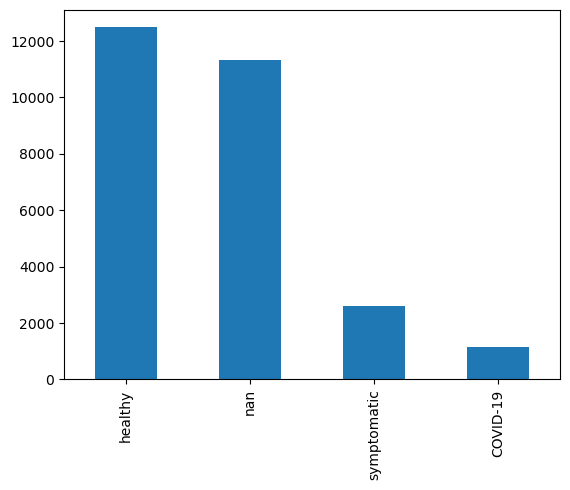

In [6]:
# some problem with this shit
pd.value_counts(df['status'], dropna=False).plot.bar()
plt.show()

c. Play a random sample from each class

In [12]:
# playing healthy
healthy = df[df['status'] == 'healthy'].sample()['uuid'].item()
path = "C:\\Users\\jespe\\Aalborg Universitet\\AVS - Semester 8 - Group 841 - Deep Learning\\Mini-Project\\Data\\" + healthy + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jespe\\Aalborg Universitet\\AVS - Semester 8 - Group 841 - Deep Learning\\Mini-Project\\Data\\36949ff2-6511-4654-9c81-a5020fbe17ba.mp3'

In [10]:
# playing COVID-19
covid = df[df['status'] == 'COVID-19'].sample()['uuid'].item()
path = "./conv/" + covid + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

In [12]:
# playing symptomatic
symptomatic = df[df['status'] == 'symptomatic'].sample()['uuid'].item()
path = "./conv/" + symptomatic + '.mp3'
y, sr = librosa.load(path)
ipd.Audio(y, rate=sr)

d. Describe if/how you think the data distribution will affect training of a classifier

e. Decide what part of the dataset to use; all, some classes, some samples. Motivate your choice

#### 2. Use a neural network of your own chose to classify the dataset. Explain your choice and at least one alternative. Document your experiences:.

#### Audio Spectogram Transformer Implementation

In [10]:
df_copy = df.copy()
df_copy = list(df_copy[pd.notna(df_copy['status'])]['status'])

A Dataset class is created to load the dataset

In [50]:
class AudioDatatset(Dataset):
    def __init__(self, audio_dir, class_csv):
        self.audio_dir = audio_dir
        self.class_csv = class_csv

        self.audio_dir_list = os.listdir(self.audio_dir)

    def __len__(self):
        return len(self.audio_dir_list)
    
    def __getitem__(self, idx):
        audio_file_path = os.path.join(self.audio_dir, self.audio_dir_list[idx])
        #print("lol: l, self.audio_dir_list[idx]: ", self.audio_dir_list[idx])
        waveform, sample_rate = ta.load(audio_file_path, normalize=True)
        transform = ta.transforms.MelSpectrogram(sample_rate, n_mels=32)
        mel_specgram = transform(waveform) 

        audio_file_name = self.audio_dir_list[idx].replace('.wav', '')

        #Transform 
        #Spectogram

        i = df[df['uuid']==audio_file_name].index.values

        label = df["status"].loc[df.index[i].values[0]]

        return mel_specgram, label 
test = AudioDatatset("./Data", "metadata_compiled.csv")

print(test.__getitem__(0))

(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2857e-05,
          1.2490e-04, 5.2214e-05],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.2420e-05,
          2.0723e-04, 2.5727e-04],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.8418e-05,
          3.4337e-04, 1.0011e-03],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2623e-07,
          1.3463e-07, 6.1563e-07],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.9435e-07,
          2.3751e-07, 6.2197e-07],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2761e-07,
          2.7147e-07, 3.3002e-07]]]), 'COVID-19')


In [52]:
class DataModuleClass(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        #self.transform = transforms.MelSpectrogram(sample_rate)
        self.batch_size = 12
    
    def prepare_data(self):
        
        pass
        #Define steps that should be done
        #only on one GPU, like getting data

    def setup(self, stage=None):
        #Apply melSpectogram transform
        self.audio_files =  AudioDatatset("./Data", "metadata_compiled.csv")
        self.train_data, self.valid_data, self.test_data = random_split(self.audio_files, [0.7,0.2,0.1], generator=torch.Generator().manual_seed(42))

        #Define steps that should be done on every GPU,
        #like splitting data, applying transform etc.

    def train_dataloader(self):
        return DataLoader(self.train_data, self.batch_size)        

    def val_dataloader(self):
        return DataLoader(self.valid_data, self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, self.batch_size)   
    
datadsds = DataModuleClass()
print(datadsds)
    

In [22]:
class ASTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        #setup up each layer
        #self.l1 = nn.Linear(28 * 28, 10)
        


    def forward(self, x):
        pass

    def training_step(self, batch, batch_idx):
        x, y = batch

    def configure_optimizers(self):
        pass

In [ ]:
s = DataModuleClass()
trainer = pl.Trainer()
model = ASTModel()

trainer.fit(model, s)

In [36]:
#Transform audio file to spectogram
PATH = './conv/'
file_name = os.listdir(PATH)[0]
print(file_name)

audio_path = PATH + file_name
print(audio_path)

y, sr = librosa.load(audio_path)
ipd.Audio(y, rate=sr)

waveform, sample_rate = ta.load(audio_path, normalize=True)
waveform = waveform.squeeze().numpy()

print(waveform.shape)
#After this we can use the feature_extractor to extract the features from the audio file
feature_extractor = ASTFeatureExtractor()
inputs = feature_extractor(waveform, sampling_rate=sample_rate, padding="max_length", return_tensors="pt")
input_values = inputs.input_values
print(input_values.shape)


00039425-7f3a-42aa-ac13-834aaa2b6b92.mp3
./conv/00039425-7f3a-42aa-ac13-834aaa2b6b92.mp3
(469440,)


a. Discuss at least four relevant hyper-parameters

b. Experiment with the effect of different batch sizes

c. Experiment with the effect of different learning rates

d. Experiment with different number of network layers

e. Implement at least two data agumentation techniques

f. Discuss what influences the memory use of a solution such as yours. What can be done to reduce this?